In [ ]:
import os
import numpy as np
import trimesh

In [5]:
def read_off_vertices(path, want_n=None, random_state=0):
    mesh = trimesh.load(path, file_type='off', force='mesh')
    verts = np.asarray(mesh.vertices, dtype=float)
    
    # 可选：统一到 want_n 个点
    if want_n is not None:
        rng = np.random.RandomState(random_state)
        n = verts.shape[0]
        if n > want_n:
            idx = rng.choice(n, want_n, replace=False)
            verts = verts[idx]
        elif n < want_n:
            idx = rng.choice(n, want_n - n, replace=True)
            verts = np.vstack([verts, verts[idx]])
    return verts

def load_fps(base_dir=".", want_n=5000):

    xt_list, T_labels = [], []
    classes = ["Microcebus", "Mirza", "Saimiri", "Tarsius"]

    for cls in classes:
        folder = os.path.join(base_dir, cls)
        if not os.path.isdir(folder):
            print(f"⚠️ Missing folder: {folder}")
            continue

        count = 0
        for fname in sorted(os.listdir(folder)):
            if fname.lower().endswith(".off"):
                fpath = os.path.join(folder, fname)
                try:
                    pts = read_off_vertices(fpath, want_n=want_n)
                    xt_list.append(pts)
                    T_labels.append(cls)
                    count += 1
                except Exception as e:
                    print(f"❌ {cls}/{fname}: {e}")
        print(f"✅ Loaded {count} files for {cls}")

    print(f"\n📊 Total loaded: {len(xt_list)} point clouds")
    print({cls: T_labels.count(cls) for cls in classes})
    return xt_list, T_labels

In [6]:
xt_list, T_labels = load_fps(r"C:\Users\xcx001\dsc180a", want_n=5000)



✅ Loaded 11 files for Microcebus
✅ Loaded 5 files for Mirza
✅ Loaded 9 files for Saimiri
✅ Loaded 33 files for Tarsius

📊 Total loaded: 58 point clouds
{'Microcebus': 11, 'Mirza': 5, 'Saimiri': 9, 'Tarsius': 33}


In [7]:
import pyLOT
from pyLOT.barycenters import LOTBarycenter
from pyLOT.embed import LOTEmbedding

In [20]:
n_ref = 5000
xr = np.random.normal(0, 1, size=(n_ref, 3))
xr.shape

(5000, 3)

In [21]:
import sys, importlib, os, time, numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
lambd = 0.05   
tic = time.time()
T_emb_sh = LOTEmbedding.embed_point_clouds(
    xr, xt_list,
    xt_masses=None,      
    sinkhorn=True,
    lambd=lambd
)

In [22]:
T_embeddings = LOTEmbedding.embed_point_clouds(
    xr,
    xt_list,
    sinkhorn=False
)

c:\Users\xcx001\anaconda3\Lib\site-packages\ot\lp\_network_simplex.py:332: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


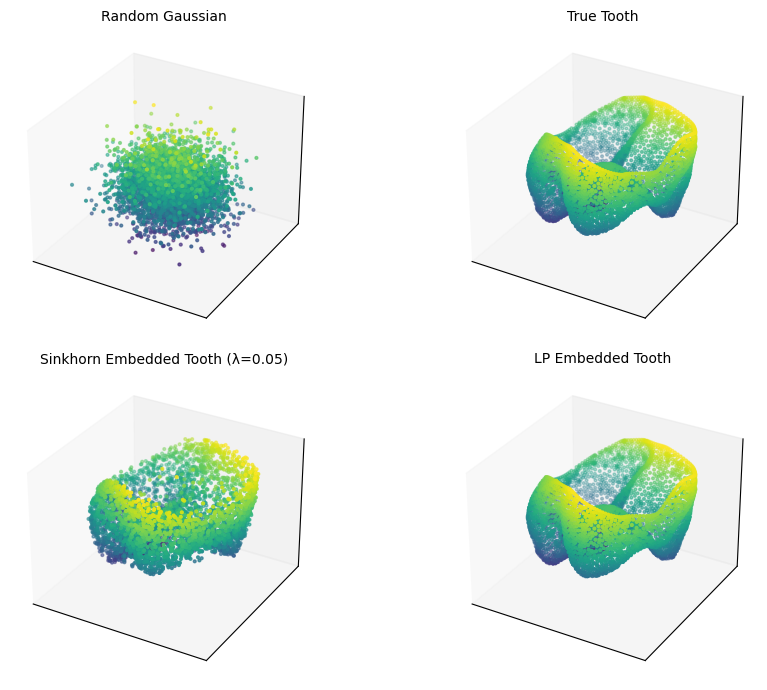

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
i = 0
xt = xt_list[i]
T_sh = T_emb_sh[i]
T_lp = T_embeddings[i]
def unflatten_emb(emb, xr):
 
    m, d = xr.shape
    emb = np.asarray(emb)
    if emb.ndim == 1:
        return emb.reshape(m, d)
    return emb[:, :d] 
T_sh = unflatten_emb(T_sh, xr)
T_lp = unflatten_emb(T_lp, xr)
def plot3d(ax, pts, title):
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
               c=pts[:, 2], cmap='viridis', s=4)
    ax.set_title(title, fontsize=10)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(221, projection='3d')
plot3d(ax1, xr, "Random Gaussian")

ax2 = fig.add_subplot(222, projection='3d')
plot3d(ax2, xt, "True Tooth")

ax3 = fig.add_subplot(223, projection='3d')
plot3d(ax3, T_sh, "Sinkhorn Embedded Tooth (λ=0.05)")

ax4 = fig.add_subplot(224, projection='3d')
plot3d(ax4, T_lp, "LP Embedded Tooth")

plt.tight_layout()
plt.show()


In [25]:

from pyLOT.reduction import LOTDimensionalityReduction
from pyLOT.classifier import LOTClassifier
T_lda, labels_bal = LOTDimensionalityReduction.lda_reduction(
    T_emb_sh, T_labels, n_components=3
)
print("LDA 输出：", T_lda.shape, len(labels_bal))

U, S, Vh, labels_bal_pca = LOTDimensionalityReduction.pca_reduction(
    T_emb_sh, T_labels
)
Z_pca = U @ np.diag(S)   
print("PCA 投影：", Z_pca.shape, len(labels_bal_pca))

LDA 输出： (132, 3) 132
PCA 投影： (132, 132) 132


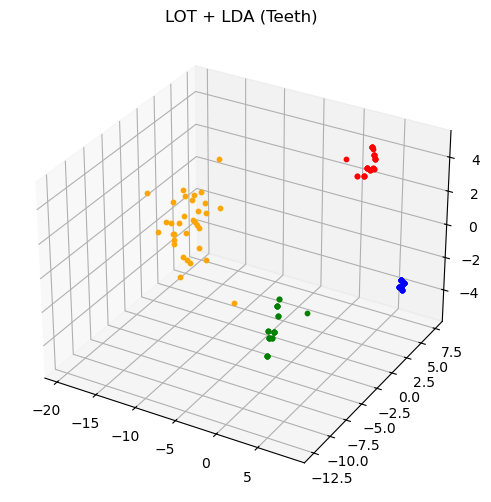

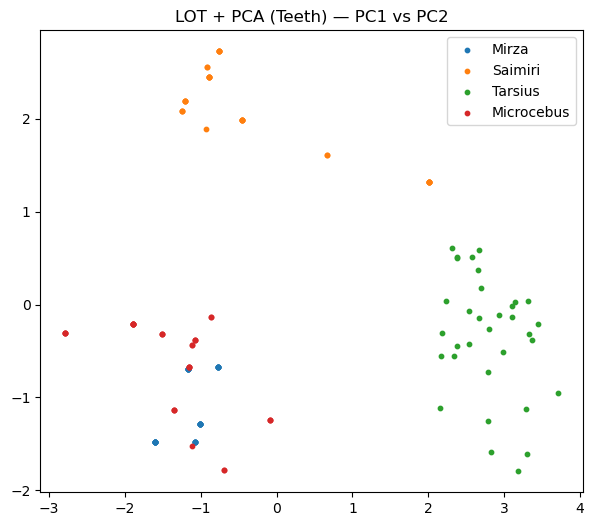

In [26]:
colors = {'Microcebus':'red','Mirza':'blue','Saimiri':'green','Tarsius':'orange'}
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
for i,lbl in enumerate(labels_bal):
    ax.scatter(T_lda[i,0], T_lda[i,1], T_lda[i,2],
               c=colors.get(lbl,'gray'), s=10)
ax.set_title("LOT + LDA (Teeth)")
plt.show()

plt.figure(figsize=(7,6))
for lbl in set(labels_bal_pca):
    idx = [i for i, v in enumerate(labels_bal_pca) if v == lbl]
    plt.scatter(Z_pca[idx,0], Z_pca[idx,1], s=10, label=lbl)
plt.title("LOT + PCA (Teeth) — PC1 vs PC2")
plt.legend()
plt.show()

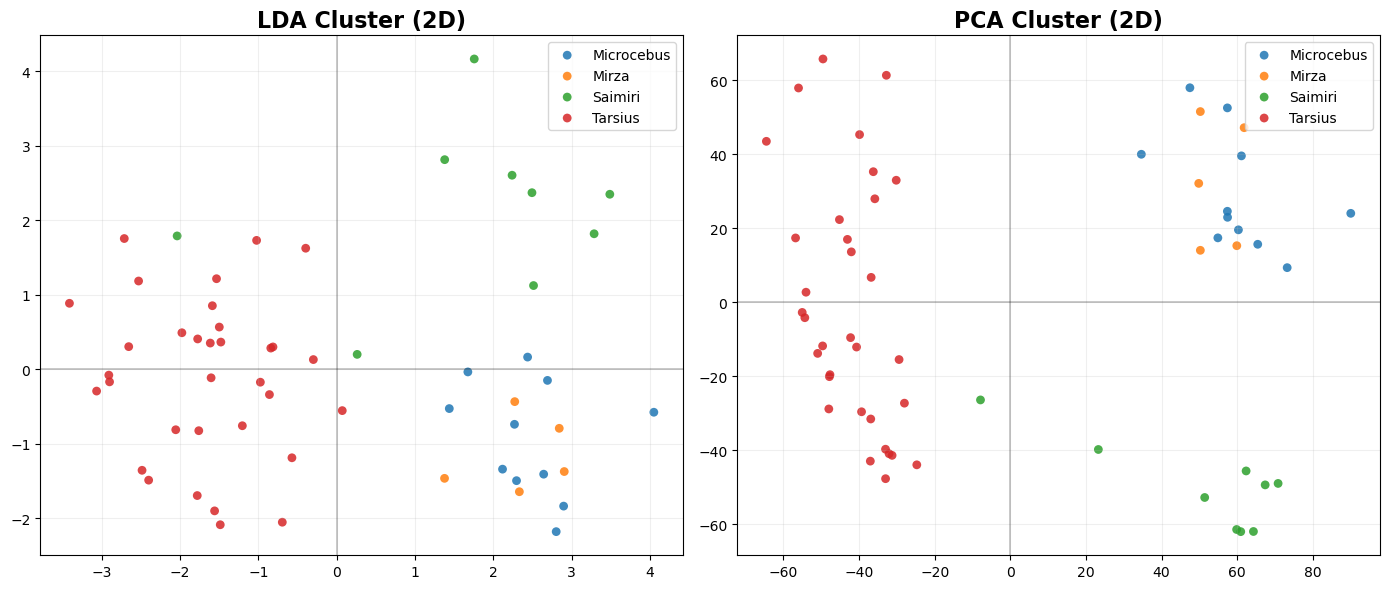

In [ ]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA


try:
    X = np.vstack(T_embeddings)
except ValueError:
   
    X = np.vstack([e.reshape(-1) for e in T_embeddings])

y = np.array(T_labels)

X_std = StandardScaler().fit_transform(X)


le = LabelEncoder()
y_enc = le.fit_transform(y)          
classes = le.classes_

Z_lda = LDA(n_components=2).fit_transform(X_std, y_enc)
Z_pca = PCA(n_components=2, random_state=0).fit_transform(X_std)

palette = {
    'Microcebus': 'tab:blue',
    'Mirza':      'tab:orange',
    'Saimiri':    'tab:green',
    'Tarsius':    'tab:red'
}

def color_for(lbl): 
    return palette.get(lbl, palette.get(lbl.lower().capitalize(), 'gray'))


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
titles = ['LDA Cluster (2D)', 'PCA Cluster (2D)']
embeds = [Z_lda, Z_pca]

for ax, title, Z in zip(axes, titles, embeds):
    for cls in classes:
        idx = (y == cls)
        ax.scatter(Z[idx, 0], Z[idx, 1], s=40, label=cls, color=color_for(cls), alpha=0.85, edgecolors='none')
    ax.set_title(title, fontsize=16, weight='bold')
    ax.grid(True, alpha=0.2)
    ax.axhline(0, color='k', lw=0.3)
    ax.axvline(0, color='k', lw=0.3)
    ax.legend(loc='upper right', frameon=True)

plt.tight_layout()
plt.show()

In [ ]:

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
rng = np.random.default_rng(42)


def to_flat(e, xr):
    e = np.asarray(e)
    if e.ndim == 2:       
        return e.reshape(-1)
    return e              

X = np.vstack([to_flat(e, xr) for e in T_embeddings]) 
y = np.array(T_labels)


def oversample_equal(X, y):
    y = np.asarray(y)
    classes, counts = np.unique(y, return_counts=True)
    n_max = counts.max()
    indices_bal = []
    for c in classes:
        idx = np.where(y == c)[0]
        if len(idx) == n_max:
            indices_bal.append(idx)
        else:
            extra = rng.choice(idx, size=n_max - len(idx), replace=True)
            indices_bal.append(np.concatenate([idx, extra]))
    idx_all = np.concatenate(indices_bal)
    return X[idx_all], y[idx_all]

X_bal, y_bal = oversample_equal(X, y)
print("Class balance after oversampling:", Counter(y_bal))


X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)


scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

candidates = {
    "KNN(k=3)": KNeighborsClassifier(n_neighbors=3),
    "Linear SVM": SVC(kernel="linear", C=1.0, probability=False, random_state=42),
    "RBF SVM": SVC(kernel="rbf", C=10.0, gamma="scale", probability=False, random_state=42)
}

cv_scores = {}
for name, clf in candidates.items():
    scores = cross_val_score(clf, X_train_std, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    cv_scores[name] = (scores.mean(), scores.std())
    print(f"{name}: CV mean={scores.mean():.4f} ± {scores.std():.4f}")

best_name = max(cv_scores, key=lambda k: cv_scores[k][0])
best_clf = candidates[best_name]
print(f"\n>>> Best by CV: {best_name}")

best_clf.fit(X_train_std, y_train)
y_pred = best_clf.predict(X_test_std)
print("\nTest accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Class balance after oversampling: Counter({'Microcebus': 33, 'Mirza': 33, 'Saimiri': 33, 'Tarsius': 33})
KNN(k=3): CV mean=0.9905 ± 0.0190
Linear SVM: CV mean=1.0000 ± 0.0000
RBF SVM: CV mean=1.0000 ± 0.0000

>>> Best by CV: Linear SVM

Test accuracy: 1.0

Classification report:
               precision    recall  f1-score   support

  Microcebus       1.00      1.00      1.00         7
       Mirza       1.00      1.00      1.00         6
     Saimiri       1.00      1.00      1.00         7
     Tarsius       1.00      1.00      1.00         7

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



C:\Users\xcx001\AppData\Local\Temp\ipykernel_19188\3393649424.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(classes))


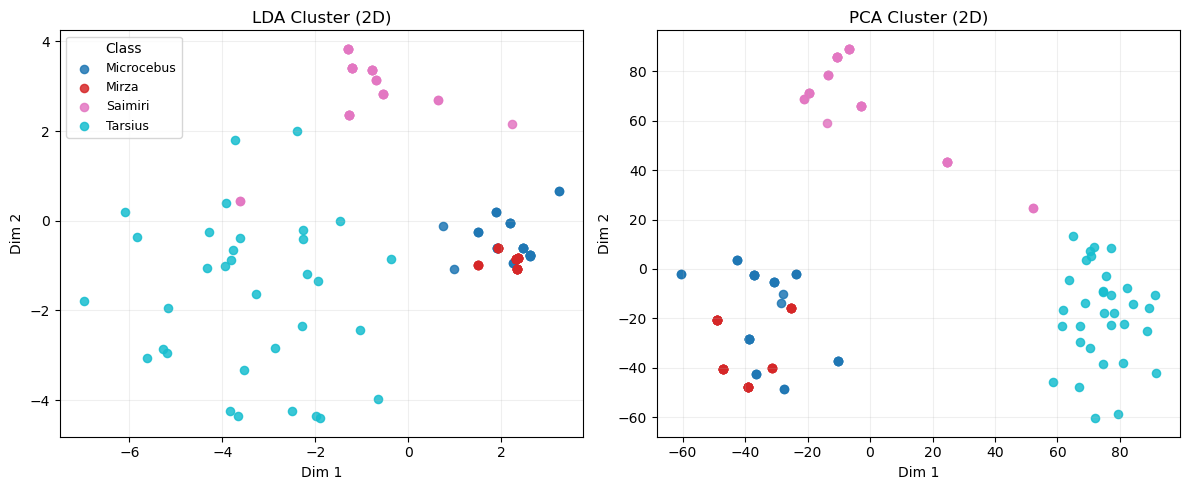

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA


X_vis = np.vstack([X_train_std, X_test_std])
y_vis = np.concatenate([y_train, y_test])

import matplotlib.cm as cm
classes = sorted(list(set(y_vis)))
colors = cm.get_cmap('tab10', len(classes))
color_map = {c: colors(i) for i,c in enumerate(classes)}

fig, axes = plt.subplots(1,2, figsize=(12,5))

# LDA (最多 C-1 维，这里取2维)
lda = LinearDiscriminantAnalysis(n_components=2)
Z_lda = lda.fit_transform(X_vis, y_vis)
for c in classes:
    idx = (y_vis == c)
    axes[0].scatter(Z_lda[idx,0], Z_lda[idx,1], s=35, color=color_map[c], label=str(c), alpha=0.85)
axes[0].set_title("LDA Cluster (2D)")
axes[0].legend(title="Class", loc='best', fontsize=9)

# PCA (2 维)
pca = PCA(n_components=2, random_state=42)
Z_pca = pca.fit_transform(X_vis)
for c in classes:
    idx = (y_vis == c)
    axes[1].scatter(Z_pca[idx,0], Z_pca[idx,1], s=35, color=color_map[c], label=str(c), alpha=0.85)
axes[1].set_title("PCA Cluster (2D)")

for ax in axes:
    ax.set_xlabel("Dim 1"); ax.set_ylabel("Dim 2"); ax.grid(alpha=0.2)

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


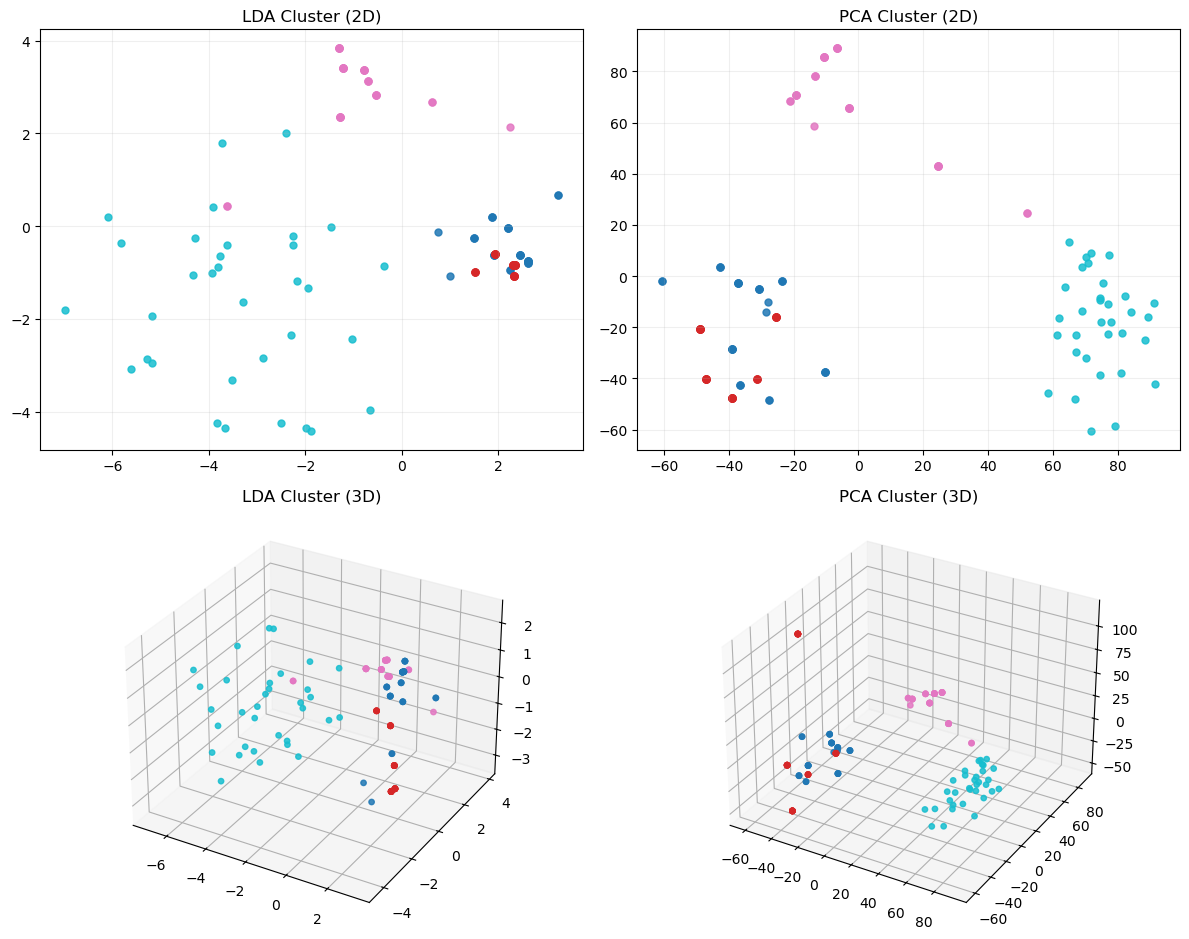

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa

fig = plt.figure(figsize=(12,10))


ax1 = fig.add_subplot(221)
for c in classes:
    idx = (y_vis == c)
    ax1.scatter(Z_lda[idx,0], Z_lda[idx,1], s=25, color=color_map[c], label=str(c), alpha=0.85)
ax1.set_title("LDA Cluster (2D)"); ax1.grid(alpha=0.2)


ax2 = fig.add_subplot(222)
for c in classes:
    idx = (y_vis == c)
    ax2.scatter(Z_pca[idx,0], Z_pca[idx,1], s=25, color=color_map[c], label=str(c), alpha=0.85)
ax2.set_title("PCA Cluster (2D)"); ax2.grid(alpha=0.2)


lda3 = LinearDiscriminantAnalysis(n_components=min(3, len(classes)-1))
Z_lda3 = lda3.fit_transform(X_vis, y_vis)
ax3 = fig.add_subplot(223, projection='3d')
for c in classes:
    idx = (y_vis == c)
    pts = Z_lda3[idx]
    if pts.shape[1] == 1:  
        pts = np.hstack([pts, np.zeros((pts.shape[0],2))])
    elif pts.shape[1] == 2:
        pts = np.hstack([pts, np.zeros((pts.shape[0],1))])
    ax3.scatter(pts[:,0], pts[:,1], pts[:,2], s=15, color=color_map[c], alpha=0.85)
ax3.set_title("LDA Cluster (3D)")


pca3 = PCA(n_components=3, random_state=42)
Z_pca3 = pca3.fit_transform(X_vis)
ax4 = fig.add_subplot(224, projection='3d')
for c in classes:
    idx = (y_vis == c)
    ax4.scatter(Z_pca3[idx,0], Z_pca3[idx,1], Z_pca3[idx,2], s=15, color=color_map[c], alpha=0.85)
ax4.set_title("PCA Cluster (3D)")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=len(classes), frameon=False)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()